In [16]:
import pandas as pd
import numpy as np 
import re
import string
import tqdm

### Get the embeddings

In [4]:
res = []
with open('../data/gdn_common_sorted.txt') as file : 
    for j, line in enumerate(file): 
        if j > 0 : 
            res.append(line.split(' ')[:701])
res = np.asarray(res)
embedding = pd.DataFrame(res[:,1:], index=res[:,0])
embeded_words = {}

for word in embedding.index : 
    embeded_words[word.split('_')[0]] = word
    
data = pd.read_csv('../data/dataset_1.csv')

### Compute variance and distance for argumentation

In [5]:
def preprocess(sentence): 
    '''
    return the sentence passed in argmuents with no punctuation
    '''
    sentence = sentence.replace('\'',' ').lower()
    table = sentence.maketrans('', '', string.punctuation)
    sentence = [w.translate(table) for w in sentence]
    sentence = ''.join(sentence)

    return sentence

In [17]:
def embed_answer(sentence): 
    sentence_embedding = []
    sentence = preprocess(sentence)
    for i, word in enumerate(sentence.split(' ')):
        try : 
            if embeded_words[word].endswith('_n'):
                sentence_embedding.append(embedding.loc[embeded_words[word]].tolist())
        except KeyError: 
            continue
    
    return(np.asarray(sentence_embedding, dtype=np.float64))
   
def compute_variance(sentence_embedding, eval_type='var'):
    result = 0
    if eval_type == 'var':
        for index in range(len(sentence_embedding[0])):
            result += np.var(sentence_embedding[:,index])
            
    elif eval_type == 'dist':
        n = len(sentence_embedding)
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += np.linalg.norm(sentence_embedding[word_1_idx]-sentence_embedding[word_2_idx])
        result = result*2/(n*(n-1))

    return result


In [14]:
data.head(5)

,Unnamed: 0,zip_code,problem,solution
0,1,57000,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...
1,5,95330,La pollution de l'air,En matière d'émission de C02 tout n'est pas di...
2,6,84750,La biodiversité et la disparition de certaines...,"Arrêter les pesticides , notamment le glyphosa..."
3,10,33820,La pollution de l'air,- Réduire de manière drastique les déplacement...
4,14,8500,Pollution air et mers,Interdire très rapidement les emballages plast...


In [11]:
n_print = 15
for i in range(n_print): 
    print(data.iloc[i]['solution'])
    print('Variance = ',compute_variance(embed_answer(data.iloc[i]['solution'])))
    print('Distance = ',compute_variance(embed_answer(data.iloc[i]['solution']),eval_type='dist'))
    print('-'*100)

Les problèmes auxquels se trouve confronté l’ensemble de la planète et que dénoncent, dans le plus parfait désordre, les gilets jaunes de France ne sont-ils pas dus, avant tout, à la surpopulation mondiale ? Cette population est passée d’1,5 milliards d’habitants en 1900 à 7 milliards en 2020 et montera bientôt à 10 milliards vers 2040.  Avec les progrès de la communication dans ce village mondial, chaque individu, du fin fond de l’Asie au fin fond de l’Afrique, en passant par les « quartiers » et les « campagnes » de notre pays, aspire à vivre – et on ne peu l’en blâmer – comme les moins mal lotis de nos concitoyens (logement, nourriture, biens de consommation, déplacement,etc.).  Voilà la mère de tous les problèmes. Si tel est bien le cas, la solution à tous les problèmes (stabilisation de la croissance démographique, partage des richesses, partage des terres, partage de l’eau, protection de la biodiversité, règlement des conflits, lutte contre la déforestation, lutte contre dérèglem

Variance =  9.76910418832498
Distance =  4.526382258871305
----------------------------------------------------------------------------------------------------
Prendre en compte le réel pour que l'action humaine, quelque que soit son échelle, s’inscrive dans les limites du réel spatial et temporel et dans le respect de chaque être humain. 
Fonder notre droit sur la réalité : 
*    La terre est finie, comme ses ressources ; 
*    La régénérations des ressources n'est pas instantanées ;
*    Nos comportements ont des conséquences à différentes échelles. Aucune ne peut être négligée.
*    Nos comportements ont des conséquences sur la durée. La résorption de l'impacte de l'action humaine n'est pas instantanée. 

*    Nul ne peu s'approprier plus que ce qui est.
*    Nul ne peut s’approprier au détriment d’autrui, ni présumer en faire meilleur usage qu'un autre.
*    Nul ne peut présumer de l'utilité ou de la non utilisation de ressources de l'humanité présente et à venir.
*    Nul ne peut 

### Let's apply it to the whole dataset, we only focus on the solution proposed

In [83]:
scores = []
word_counter = []
freq = []

for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>1:
        scores.append([compute_variance(answer, eval_type='var'),
                       compute_variance(answer, eval_type='dist')])
    else:
        scores.append([np.nan, np.nan])
        
    nb_words = len(preprocess(data.iloc[index]['solution']).split(' '))
    word_counter.append(nb_words)
    
unique_nb_words = np.unique(word_counter, return_counts=True)
nb_words_occ = {}
for nb_words, occ in zip(unique_nb_words[0],unique_nb_words[1]):
    nb_words_occ[nb_words] = occ
    
for nb_words in word_counter:
    freq.append(nb_words_occ[nb_words])
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns=['Variance', 'Distance'])
word_counter_df = pd.DataFrame(data=np.array(word_counter),index=data.index, columns=['Nb_words'])
freq_df = pd.DataFrame(data=np.array(freq),index=data.index, columns=['Freq'])
argumentation_scores = pd.concat([data['zip_code'], scores_df, word_counter_df, freq_df], axis=1)
argumentation_scores.head(5)

100%|██████████| 15309/15309 [15:06<00:00, 16.89it/s] 


,zip_code,Variance,Distance,Nb_words,Freq
0,57000,11.409198,4.692798,210,14
1,95330,11.528705,4.724833,375,4
2,84750,10.190912,4.523009,92,81
3,33820,12.596419,5.154212,57,169
4,8500,11.339546,4.736561,72,112


(0, 200)

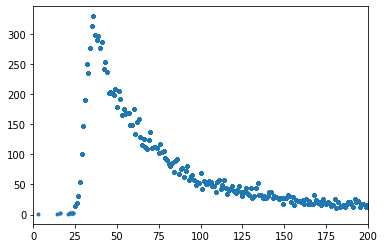

In [93]:
import matplotlib.pyplot as plt
plt.plot(argumentation_scores['Nb_words'].values, argumentation_scores['Freq'].values, marker='.', linestyle=' ')
plt.xlim(left=0,right=200)

### Normalisation of the values

In [98]:
# First : let's get the values associated to each nb of words.
word_counter = []
for index in tqdm.tqdm(range(len(data))):
    nb_words = len(preprocess(data.iloc[index]['solution']).split(' '))
    word_counter.append(nb_words)

with_counter = pd.concat([argumentation_scores, pd.DataFrame(np.array(word_counter))], axis=1)

# Then, let's compute the mean and variance values of the variances (resp. distance) 
# with respect to the number of words.
normalized_scores = pd.DataFrame(np.copy(argumentation_scores), columns=argumentation_scores.columns)

unique_word_nb = np.unique(word_counter, return_counts=True)
for word_nb, freq in zip(unique_word_nb[0],unique_word_nb[1]):
    for eval_type in ['Variance', 'Distance']:
        if freq>1:
            corresponding_values=[]
            indexes=[]
            for idx in np.where(np.array(word_counter)==word_nb)[0]:
                if not np.isnan(argumentation_scores.iloc[idx][eval_type]): 
                    # If only one word or less is embedded, then the variance and distance value are nan
                    # and we mustn't consider them in the normalisation...
                    corresponding_values.append(argumentation_scores.iloc[idx][eval_type])
                    indexes.append(idx)

            mean_value = np.mean(corresponding_values)
            var_value = np.var(corresponding_values)

            for idx in indexes:
                normalized_scores.iloc[idx][eval_type] -= mean_value
                normalized_scores.iloc[idx][eval_type] /= var_value
                
normalized_scores.columns = ['zip_code','Variance_std','Distance_std','Nb_words','Freq']

100%|██████████| 15309/15309 [00:09<00:00, 1617.22it/s]


In [120]:
department = np.copy(normalized_scores['zip_code'].values)
for dpt_idx in range(len(department)):
    department[dpt_idx] = int(department[dpt_idx]/1000)

department_df = pd.DataFrame(department, columns=['Department'],dtype=int)
normalized_scores['Freq'] = normalized_scores['Freq'].astype(int)
normalized_scores['Nb_words'] = normalized_scores['Nb_words'].astype(int)
normalized_scores['zip_code'] = normalized_scores['zip_code'].astype(int)

final_data = pd.concat([department_df, normalized_scores], axis=1)
final_data.head()

,Department,zip_code,Variance_std,Distance_std,Nb_words,Freq
0,57,57000,0.030403,-0.155042,210,14
1,95,95330,7.366155,24.467287,375,4
2,84,84750,-0.903159,-3.502173,92,81
3,33,33820,1.308907,5.060375,57,169
4,8,8500,0.318688,0.574891,72,112


### Let's plot the histograms Occ=f(Var) and Occ=f(Dist)

75 -0.006621944366089543 0.5963682465183103
69 0.017319506528434763 0.7855021367351975
31 -0.03552666671367933 0.558634467978296
13 -0.013885796561705419 0.7029176792468048
92 -0.024974357899257275 0.6015896991305
33 0.015778590071330187 0.7703961684785288
78 0.009681527074468791 0.6789569641293415
38 0.07406738314102501 0.5706020596055605
44 -0.04472198626073613 0.8111570273242752
59 -0.03912266163627263 0.6242805805551096
34 0.08918042949971629 0.6458379529478988
94 -0.027486388966462952 0.5649890048145221
91 -0.03248305589545725 0.8160886992012109
83 0.08342924256155768 0.6578744676098583
6 0.004344291095173392 0.5496675823077474
77 -0.020128209938276832 0.8145127714960524
35 -0.015813054539273664 0.7096283528190451
67 0.11960910756206514 0.5458841788731351
74 0.04441499837192835 0.619497114594083
76 -0.03715610019130664 0.5518114725838184
29 -0.10216751236330199 0.5251930970685597
30 -0.015308174894120109 0.5984645241941073
63 0.060916042200813425 0.7128373253188911
1 0.01663887067

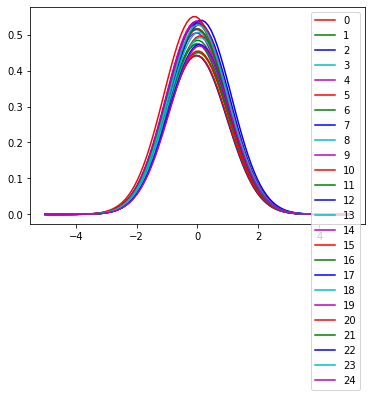

In [173]:
# Let's plot the hist for the most represented department
colors = ['r','g','b','c','m']
unique_dpt = np.unique(final_data['Department'], return_counts=True)
dpts = unique_dpt[0]
counts = unique_dpt[1]
for k in range(25):
    max_dpt_idx = np.argmax(counts)
    max_dpt = dpts[max_dpt_idx]

    values = final_data[final_data['Department']==max_dpt]['Variance_std'].dropna().values
    percentile = np.percentile(abs(values),95)
    valid_values = values[abs(values)<percentile]
    
    M = np.mean(valid_values)
    V = np.var(valid_values)
    print(max_dpt,M,V)
    gauss_pdf = lambda x,V,M: 1/np.sqrt(2*np.pi*V) * np.exp(-.5*(x-M)**2)
    X = np.linspace(-5,5,100)
    Y = []
    for elt in X:
        Y.append(gauss_pdf(elt,V,M))

    #final_data[final_data['Department']==max_dpt]['Variance_std'].hist(bins=2000, alpha=0.5)
    plt.plot(X,Y,color=colors[k%5],label=k)
    #plt.xlim(right=-5, left=5)
    #plt.ylim(bottom=0, top=2)
    counts = np.delete(counts,max_dpt_idx)
    dpts = np.delete(dpts,max_dpt_idx)
plt.legend()
plt.show()

### Let's add the values to the dataframe

In [198]:
# Let's plot the hist for the most represented department
unique_dpt = np.unique(final_data['Department'], return_counts=True)[0]
mapping = {}
for dpt in unique_dpt:
    values = final_data[final_data['Department']==dpt]['Variance_std'].dropna().values
    try:
        percentile = np.percentile(abs(values),95)
        valid_values = values[abs(values)<percentile]

        M = np.mean(valid_values)
        V = np.var(valid_values)
    except:
        M, V = np.nan, np.nan
    
    mapping[dpt] = [M,V]
    
vars_means = []
for index in range(len(final_data)):
    vars_means.append(mapping[final_data['Department'][index]][0])

vars_means = pd.DataFrame(vars_means, index=final_data.index, columns=['Variance_mean_wrt_dpt'])
final_data = pd.concat([final_data, vars_means], axis=1)

In [199]:
final_data

,Department,zip_code,Variance_std,Distance_std,Nb_words,Freq,Variance_mean_wrt_dpt,Variance_mean_wrt_dpt
0,57,57000,0.030403,-0.155042,210,14,0.037152,0.037152
1,95,95330,7.366155,24.467287,375,4,0.073731,0.073731
2,84,84750,-0.903159,-3.502173,92,81,-0.034868,-0.034868
3,33,33820,1.308907,5.060375,57,169,0.015779,0.015779
4,8,8500,0.318688,0.574891,72,112,0.086564,0.086564
...,...,...,...,...,...,...,...,...
15304,33,33320,1.723069,6.796410,180,25,0.015779,0.015779
15305,17,17430,-0.230708,0.342578,31,190,0.053996,0.053996
15306,38,38340,0.820622,0.647585,67,112,0.074067,0.074067
15307,75,75017,-0.677069,-1.813858,289,10,-0.006622,-0.006622


In [183]:
from pyensae import download_data
import os
try:
    download_data("GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z",
                  website="https://wxs-telechargement.ign.fr/oikr5jryiph0iwhw36053ptm/telechargement/inspire/" + \
                          "GEOFLA_THEME-DEPARTEMENTS_2015_2$GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01/file/")
except Exception as e:
    # au cas le site n'est pas accessible
    download_data("GGEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z", website="xd")
    
#############################################################################################################

from pyquickhelper.filehelper import un7zip_files
try:
    un7zip_files("GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z", where_to="shapefiles")
    departements = 'shapefiles/GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01/GEOFLA/1_DONNEES_LIVRAISON_2015/' + \
                   'GEOFLA_2-1_SHP_LAMB93_FR-ED152/DEPARTEMENT/DEPARTEMENT.shp'
except FileNotFoundError as e:
    # Il est possible que cette instruction ne fonctionne pas.
    # Dans ce cas, on prendra une copie de ce fichier.
    import warnings
    warnings.warn("Plan B parce que " + str(e))
    download_data("DEPARTEMENT.zip")
    departements = "DEPARTEMENT.shp"

if not os.path.exists(departements):
    raise FileNotFoundError("Impossible de trouver '{0}'\ncurrent folder: '{1}'".format(
        departements, os.getcwd()))
    
#############################################################################################################

shp = departements
import shapefile
r = shapefile.Reader(shp)
shapes = r.shapes()
records = r.records()
len(shapes), len(records)


#############################################################################################################

import math

def lambert932WGPS(lambertE, lambertN):

    class constantes:
        GRS80E = 0.081819191042816
        LONG_0 = 3
        XS = 700000
        YS = 12655612.0499
        n = 0.7256077650532670
        C = 11754255.4261

    delX = lambertE - constantes.XS
    delY = lambertN - constantes.YS
    gamma = math.atan(-delX / delY)
    R = math.sqrt(delX * delX + delY * delY)
    latiso = math.log(constantes.C / R) / constantes.n
    sinPhiit0 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * math.sin(1)))
    sinPhiit1 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit0))
    sinPhiit2 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit1))
    sinPhiit3 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit2))
    sinPhiit4 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit3))
    sinPhiit5 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit4))
    sinPhiit6 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit5))

    longRad = math.asin(sinPhiit6)
    latRad = gamma / constantes.n + constantes.LONG_0 / 180 * math.pi

    longitude = latRad / math.pi * 180
    latitude = longRad / math.pi * 180

    return longitude, latitude

lambert932WGPS(99217.1, 6049646.300000001), lambert932WGPS(1242417.2, 7110480.100000001)

((-4.1615802638173065, 41.303505287589545),
 (10.699505053975292, 50.852433955535844))

In [184]:
from cartopy.feature import NaturalEarthFeature, COLORS
resolution = "50m"
BORDERS = NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                              resolution, edgecolor='black', facecolor='none')
STATES = NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes',
                             resolution, edgecolor='black', facecolor='none')
COASTLINE = NaturalEarthFeature('physical', 'coastline', resolution,
                                edgecolor='black', facecolor='none')
LAKES = NaturalEarthFeature('physical', 'lakes', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'])
LAND = NaturalEarthFeature('physical', 'land', resolution,
                           edgecolor='face',
                           facecolor=COLORS['land'], zorder=-1)
OCEAN = NaturalEarthFeature('physical', 'ocean', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'], zorder=-1)
RIVERS = NaturalEarthFeature('physical', 'rivers_lake_centerlines', resolution,
                             edgecolor=COLORS['water'],
                             facecolor='none')

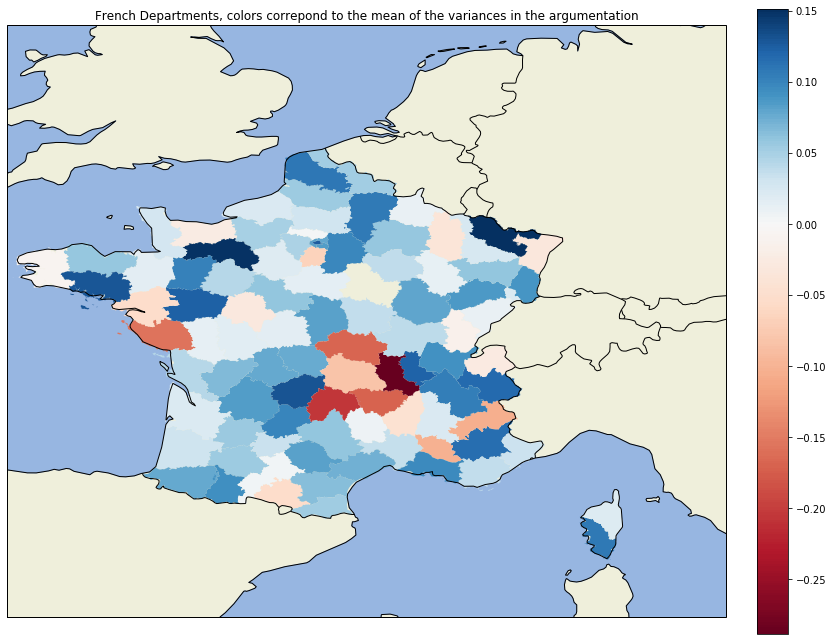

In [240]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geoplot
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.add_feature(BORDERS)
#ax.add_feature(LAKES)
ax.add_feature(LAND)
ax.add_feature(OCEAN)
#ax.add_feature(RIVERS)
ax.add_feature(COASTLINE)
ax.set_extent([-5, 12, 40, 54])
ax.set_title("French Departments, colors correpond to the mean of the variances in the argumentation")
#ax.gridlines(crs=projection, draw_labels=True,
#             linewidth=2, color='gray', alpha=0.5, linestyle='--')

from matplotlib.collections import LineCollection
import shapefile
import geopandas
from shapely.geometry import Polygon
from shapely.ops import cascaded_union, unary_union
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

shp = departements
r = shapefile.Reader(shp)
shapes = r.shapes()
records = r.records()

polys = []
for i, (record, shape) in enumerate(zip(records, shapes)):
    # les coordonnées sont en Lambert 93
    if i == 0:
        continue #print(record, shape.parts)
    geo_points = [lambert932WGPS(x,y) for x, y in shape.points]
    if len(shape.parts) == 1:
        # Un seul polygone
        poly = Polygon(geo_points)
    else:
        # Il faut les fusionner.
        ind = list(shape.parts) + [len(shape.points)]
        pols = [Polygon(geo_points[ind[i]:ind[i+1]]) for i in range(0, len(shape.parts))]
        try:
            poly = unary_union(pols)
        except Exception as e:
            print("Cannot merge: ", record)
            print([_.length for _ in pols], ind)
            poly = Polygon(geo_points)
    polys.append(poly)

data = geopandas.GeoDataFrame(geometry=polys)
# cmap -> voir https://matplotlib.org/users/colormaps.html
#data.plot(ax=ax, cmap='RdBu', edgecolor='black');
# Ou pour définir des couleurs spécifiques.
Colors = []
for dpt in data.index:
    Colors.append(mapping[dpt][0])
    
Colors = pd.DataFrame(Colors, index=data.index, columns=['colors'])
data = pd.concat([data, Colors], axis=1)
geopandas.plotting.plot_polygon_collection(ax, data['geometry'], data['colors'], 
                                           vmin=np.min(Colors), vmax=np.max(Colors), cmap='RdBu')#, values=None)
#ax.legend()
vmin, vmax, vcenter = Colors.min().values[0], Colors.max().values[0], 0
divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# create a normalized colorbar
cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='RdBu')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(cbar, ax=ax, fraction=0.04, pad=0.04)